# Creating binaries 

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import build_synthetic_set as models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman 
import warnings
import re

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


### Generate the models

In [2]:
data = pd.read_csv('../asu2.tsv',skiprows=38,sep='\t')
data = data.drop(data.index[:2])
data['Sectors'] = data['Sectors'].str.split(',')
data = data.explode('Sectors')
data.TIC = data.TIC.astype(int)
data.Sectors = pd.to_numeric(data['Sectors'], errors='coerce')
data.Per = pd.to_numeric(data['Per'], errors='coerce')
data.BJD0 = pd.to_numeric(data['BJD0'], errors='coerce')

len(data)

12224

In [3]:
lightcurves = glob('../data/binary-files/*.fits', recursive=True)
ldf = pd.DataFrame(lightcurves)
ldf.columns = ['filepath']
ldf['TIC'] = ldf['filepath'].apply(lambda x: int(re.search(r'(\d{16})', x).group(1)))
ldf['Sectors'] = ldf['filepath'].apply(lambda x: int(re.search(r's(\d{4})', x).group(1)))
len(ldf)

12101

In [4]:
test = pd.merge(data, ldf, on=['TIC','Sectors'])
test = test[['TIC','BJD0','Per','filepath','Sectors']]
test.head()

,TIC,BJD0,Per,filepath,Sectors
0,185259483,1544.164633,0.310564,../data/binary-files/hlsp_gsfc-eleanor-lite_te...,9.0
1,307990280,1546.118024,2.315912,../data/binary-files/hlsp_gsfc-eleanor-lite_te...,9.0
2,307990280,1546.118024,2.315912,../data/binary-files/hlsp_gsfc-eleanor-lite_te...,10.0
3,307990280,1546.118024,2.315912,../data/binary-files/hlsp_gsfc-eleanor-lite_te...,11.0
4,387178621,1548.193069,8.187126,../data/binary-files/hlsp_gsfc-eleanor-lite_te...,9.0


In [5]:
# Define the range to search for minimum flux
search_range = 5

# Create an empty dataframe to store the results
results = pd.DataFrame(columns=['TIC', 'tpeak'])

tics = []
times = []
folder = '../binaries'
os.makedirs(folder,exist_ok=True)
timearr = []
fluxarr = []
for row in tqdm(test.itertuples(index=False, name=None)):
    id_, first_eclipse, period, filepath, sector = row
    lc, lc_info = import_lightcurve(filepath)
    sector = lc_info['Sector']
    timearr.append(lc['TIME'].value)
    fluxarr.append(lc['PCA_FLUX'].value)
    np.save(f"{folder}/{lc_info['TIC_ID']}_sector{sector}.npy", np.array([lc['TIME'].value, lc['PCA_FLUX'].value/np.nanmedian(lc['PCA_FLUX']), lc['FLUX_ERR'].value]))
    
# fig, axs = plt.subplots(10, 10, figsize=(20, 20))

# for i, ax in enumerate(axs.flat):
#     if i < len(timearr):
#         ax.plot(timearr[i], fluxarr[i])
#         ax.set_title(f'Plot {i+1}')

#     else:
#         ax.axis('off')  # Turn off the subplot if there's no data to plot

# plt.tight_layout()
# plt.show()

#     first_eclipse = float(first_eclipse)
#     period = float(period)
    
#     # Start with the time of the first eclipse
#     t_exp = first_eclipse
    
#     while True:
#         time = lc['TIME'].value
#         flux = lc['PCA_FLUX'].value
        
#         # Check if the expected time is within the time range of the lightcurve
#         if t_exp < np.min(time) or t_exp > np.max(time):
#             break
        
#         # Find the indices where the time is within the search range
#         indices = np.where(np.abs(time - t_exp) <= search_range)[0]
        
#         # Check if there is a minimum flux within the search range
#         if len(indices) > 0:
#             min_flux_idx = indices[np.argmin(flux[indices])]
#             min_flux_time = time[min_flux_idx]
            
#             # Append the transit time and ID to the lists
#             tics.append(id_)
#             times.append(min_flux_time)
        
#         # Calculate the next expected transit time
#         t_exp += period

# # Create the results DataFrame from the lists
# results = pd.DataFrame({'TIC': tics, 'tpeak': times})


9276it [02:40, 57.96it/s]


In [6]:
def calculate_transit_times(BJD0, period, start, end):
    transit_times = []
    n = 0
    while True:
        T_n = BJD0 + n * period
        if T_n > end:
            break
        if T_n >= start:
            transit_times.append(T_n)
        n += 1
    return transit_times

def process_row(row):
    sector_index = row['Sectors'] - 1  # Assuming sector numbering starts from 1
    sector_index = int(sector_index)
    sector_times = lightcurves[sector_index]
    return calculate_transit_times(np.array(row['BJD0']), np.array(row['Per']), sector_times[0], sector_times[-1])


processed_sectors = {}
lightcurves = []

for index, row in tqdm(test.iterrows()):
    sector = row['Sectors']
    filepath = row['filepath']
    
    # Check if this sector has already been processed
    if sector not in processed_sectors:
        # Download the lightcurve (placeholder code, replace with actual download code)
        lightcurve_data, _ = import_lightcurve(filepath)
        
        # Append the lightcurve data to the list
        lightcurves.append(lightcurve_data['TIME'].value)
        
        # Mark this sector as processed
        processed_sectors[sector] = True

lightcurves = sorted(lightcurves, key=lambda x: x[0])

9276it [00:00, 11620.32it/s]


---

In [7]:
data1 = data[data.Sectors == 7]

In [8]:
tqdm.pandas()
data1['Transit_Times'] = data1.progress_apply(process_row, axis=1)
data1 = data1.explode('Transit_Times')

100%|█| 338/338 [00:00<00:00, 995
/var/folders/bv/h7ss9cs93lq15v21yc62bk600000gn/T/ipykernel_85452/2724822786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Transit_Times'] = data1.progress_apply(process_row, axis=1)


In [9]:
# binary = np.load('../binaries/279955276_sector7.npy')
# plt.plot(binary[0],binary[1])
# for transit_time in list(data[data.TIC == 279955276]['Transit_Times'])[0]:
#     plt.axvline(x=transit_time, color='r', linestyle='--')


In [15]:
#data = pd.DataFrame(data=[ticid,times]).T
data1['tpeak'] = data1['Transit_Times']
data1 = data1.dropna(subset=['Transit_Times'])


In [17]:
t = Table.from_pandas(data1)
t.write('binaries-catalog.txt', format='ascii', overwrite=True) 

In [26]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/binaries/',
                         catalog='/Users/azib/Documents/open_source/nets2/notebooks/binaries-catalog.txt',cadences=168,training=0.8,validation=0.9)

Reading in training set files.


100%|█| 9266/9266 [00:04<00:00, 2


2600 positive classes (flare)
6110 negative classes (no flare)
43.0% class imbalance



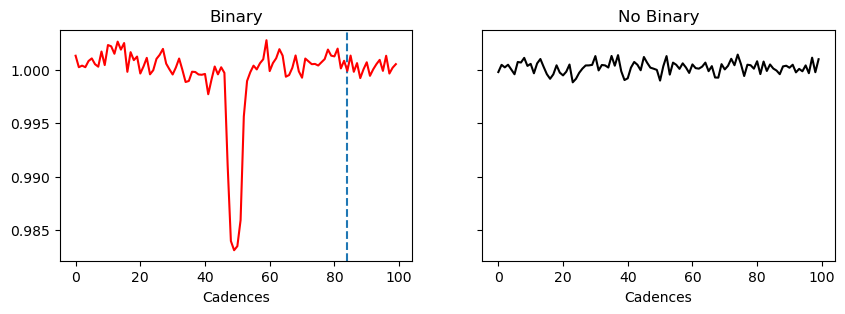

In [25]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[1]], 'r',zorder=5)
ax1.axvline(84,linestyle='--')
ax1.set_title('Binary')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[0]], 'k')
ax2.set_title('No Binary')
ax2.set_xlabel('Cadences');

In [36]:
ds.ids[ind_pc[18]]

110428269

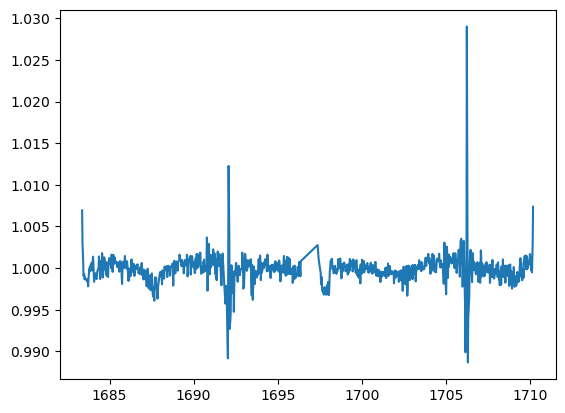

In [37]:
m = np.load('../binaries/110428269_sector14.npy')
plt.plot(m[0],m[1])

In [27]:
dsmodels = ds.train_data[ind_pc]
dsnomodels = ds.train_data[ind_nc]

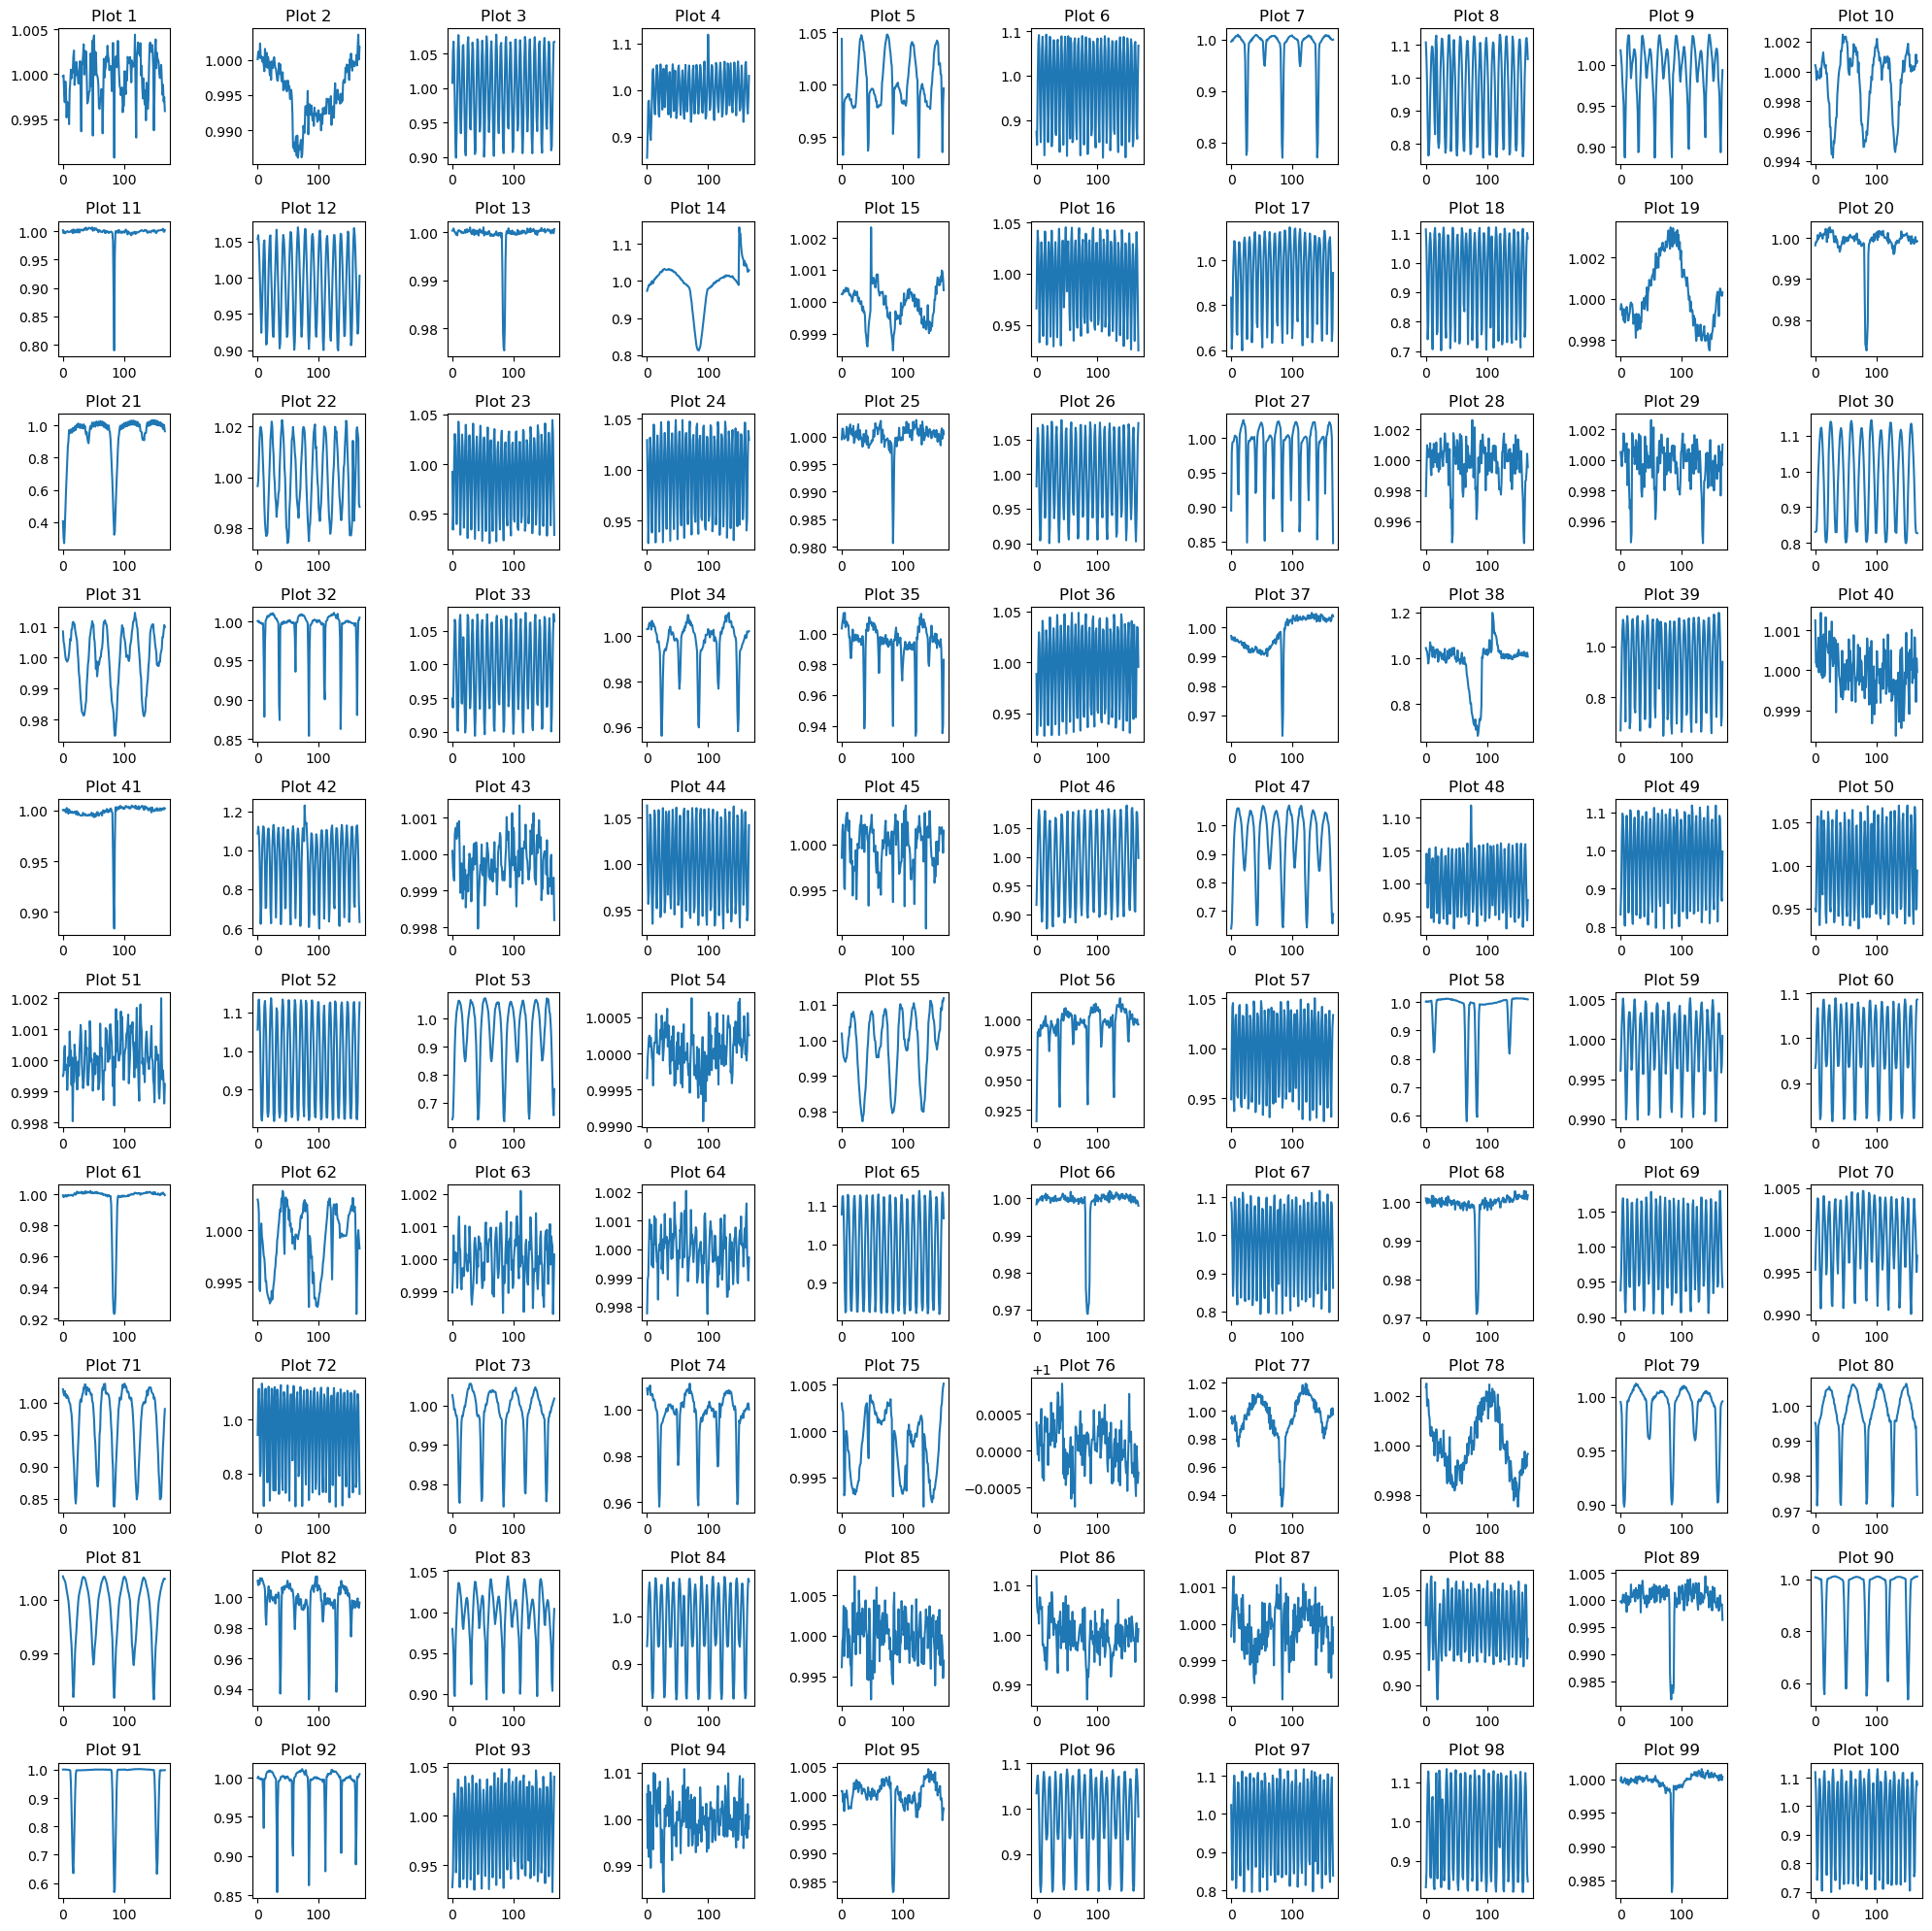

In [28]:
num_sets = dsmodels.shape[0] // 100

for set_index in range(num_sets):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    #plt.savefig('example-models.png',dpi=200,bbox_inches='tight')
    plt.show()  # Show the grid of plots
    break

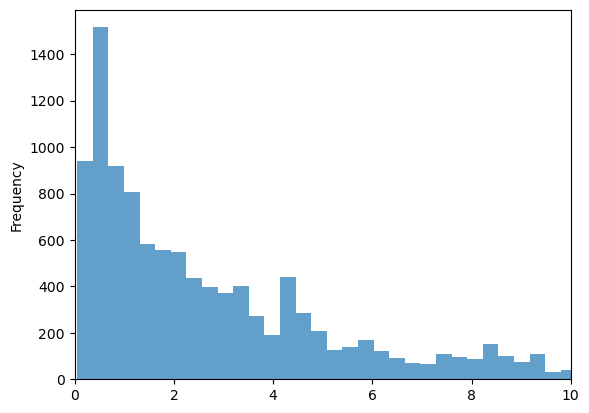

In [35]:
data['Per'].plot.hist(bins=1000, alpha=0.7)
plt.xlim(0,5)
plt.show()